# Lecture 14: Trimming and Filtering Messages in LangGraph

### Setup the LLM

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()  # Load environment variables from .env file

# Corrected way to retrieve the API key
api_key = os.getenv("GOOGLE_API_KEY")

if not api_key:
    raise ValueError("GOOGLE_API_KEY not found. Make sure it's set in the .env file.")

os.environ["GOOGLE_API_KEY"] = api_key

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

In [3]:
print(llm.invoke("What is the meaning of life?").content)

There's no single, universally accepted answer to the meaning of life.  The question itself is philosophical and has been pondered by humans for millennia.  Different individuals and cultures find meaning in various things, including:

* **Relationships:**  Love, family, friendship, and community provide a sense of belonging and purpose for many.
* **Contribution:** Making a positive impact on the world, whether through work, volunteering, or creative expression, can be deeply fulfilling.
* **Growth and learning:**  Continuously expanding one's knowledge, skills, and understanding can give life a sense of direction and achievement.
* **Spiritual or religious beliefs:**  Faith and connection to a higher power provide meaning and guidance for many people.
* **Experiences:**  Travel, adventure, and pursuing passions can create lasting memories and a sense of fulfillment.
* **Self-discovery:**  Understanding oneself, one's values, and one's place in the world is a lifelong journey that can

In [4]:
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage

messages = [AIMessage(f"So you like AI?", name="Bot")]
messages.append(HumanMessage(f"Yes, I do, but how to learn more about it? please give me a roadmap.", name="Asif"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you like AI?
================================ Human Message =================================
Name: Asif

Yes, I do, but how to learn more about it? please give me a roadmap.


In [5]:
response = llm.invoke(messages)
pprint(response.content)

("Learning about AI is a journey, not a sprint.  Here's a roadmap, broken down "
 'into stages, catering to different learning styles and goals:\n'
 '\n'
 '**Stage 1: Foundational Knowledge (1-3 months)**\n'
 '\n'
 '* **Mathematics:**  A solid foundation in math is crucial. Focus on:\n'
 '    * **Linear Algebra:** Vectors, matrices, operations, eigenvalues, '
 'eigenvectors.  Khan Academy, 3Blue1Brown (YouTube), and MIT OpenCourseware '
 'are excellent resources.\n'
 '    * **Calculus:** Derivatives, integrals, gradients.  Again, Khan Academy, '
 '3Blue1Brown, and MIT OpenCourseware are great.\n'
 "    * **Probability and Statistics:** Probability distributions, Bayes' "
 'theorem, hypothesis testing, statistical significance.  Khan Academy, edX, '
 'and Coursera offer relevant courses.\n'
 '* **Programming:**  Python is the dominant language in AI. Learn the '
 'basics:\n'
 '    * **Data structures:** Lists, dictionaries, sets, tuples.\n'
 '    * **Control flow:** Loops, conditional s

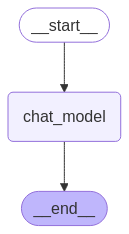

In [7]:
from IPython.display import display, Image
from langgraph.graph import START, StateGraph, END
from langgraph.graph import MessagesState

# Nodes are units of work that can be executed in the graph. They are typically regular python functions.

# Always start by defining a StateGraph. A StateGraph object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}


# Edge is connection between nodes
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you like AI?
================================ Human Message =================================
Name: Asif

Yes, I do, but how to learn more about it? please give me a roadmap.
================================== Ai Message ==================================

Learning about AI is a vast undertaking, so a roadmap depends on your background and goals.  Are you aiming for a casual understanding, a professional career, or something in between?  Let's assume a path toward a solid understanding, adaptable to different levels.

**Phase 1: Foundational Knowledge (1-3 months)**

* **Mathematics:**
    * **Linear Algebra:** Vectors, matrices, operations, eigenvalues/eigenvectors.  Khan Academy, 3Blue1Brown (YouTube) are excellent resources.  Crucial for understanding neural networks.
    * **Calculus:** Derivatives, gradients, integrals.  Again, Khan Academy and 3Blue1Brown are great.  Necessary for optim

Points if we pass the entire conversation

1. High cost
2. Slow response times/ Hight Latency
3. High token usage

### Filtering the messages

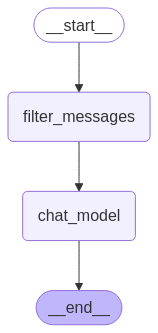

In [9]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    # This function takes the current state of the messages and creates a list of RemoveMessage objects for all messages except the last two.

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter_messages", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter_messages")
builder.add_edge("filter_messages", "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [10]:
# Message list with a preamble
messages = [AIMessage(f"Hi there!", name="Bot", id="1")]
messages.append(HumanMessage(f"Hi there, how are you?", name="Lance", id="2"))
messages.append(AIMessage(f"I am doing well, so you said you were researching AI?", name="Bot", id="3"))
messages.append(HumanMessage(f"Yes, I know about AI. But what other topics should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()


================================== Ai Message ==================================
Name: Bot

I am doing well, so you said you were researching AI?
================================ Human Message =================================
Name: Lance

Yes, I know about AI. But what other topics should I learn about?
================================== Ai Message ==================================

That's great!  Knowing about AI is a fantastic starting point.  What you should learn next depends heavily on your goals.  To recommend relevant topics, I need a bit more information.  For example:

* **What aspects of AI are you interested in?** (e.g., Machine Learning, Natural Language Processing, Computer Vision, Robotics, AI ethics, AI safety, AI business applications)
* **What's your current background?** (e.g., programmer, data scientist, business professional, student, hobbyist)
* **What are your goals for learning about AI?** (e.g., build an AI application, understand AI's societal impact, switch 

### Trimming the messages

### Trimming happens at tokens level

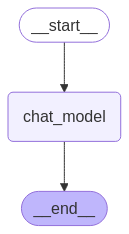

In [11]:
from langchain_core.messages import trim_messages

# Node 
def chat_model_node(state: MessagesState):
    messages = trim_messages(
        state["messages"],
        max_tokens=100,
        token_counter=llm,
        strategy="last",
        allow_partial=False,
    )

    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [12]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name='Lance'))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi there!
================================ Human Message =================================
Name: Lance

Hi there, how are you?
================================== Ai Message ==================================
Name: Bot

I am doing well, so you said you were researching AI?
================================ Human Message =================================
Name: Lance

Yes, I know about AI. But what other topics should I learn about?
================================== Ai Message ==================================

That's great!  Knowing about AI is a fantastic starting point.  What you should learn next depends heavily on your goals.  To recommend relevant topics, I need a bit more information.  For example:

* **What aspects of AI are you interested in?** (e.g., Machine Learning, Natural Language Processing, Computer Vision, Robotics, AI ethics, AI safety, AI business applications)
* **What's your c

In [14]:
list_of_messages = [
    ("user", "Hi, I'm Asif"),
    ("bot", "Hi Asif, how are you?"),
    ("user", "I'm doing well, how about you?"),
    ("bot", "I'm doing well too, thanks for asking!"),
    ("user", "What's your favorite color?"),
    ("bot", "My favorite color is blue!"),
    ("user", "That's a nice color. What's your favorite food?"),
    ("bot", "My favorite food is pizza!"),
    ("user", "Pizza sounds delicious. What's your favorite movie?"),
    ("bot", "My favorite movie is The Matrix."),
    ("user", "The Matrix is a classic. What's your favorite book?"),
    ("bot", "My favorite book is The Catcher in the Rye."),
    ("user", "The Catcher in the Rye is a great book. What's your favorite sport?"),
    ("bot", "My favorite sport is basketball!"),
    ("user", "Basketball is a fun sport. What's your favorite TV show?"),   
    ("bot", "My favorite TV show is Breaking Bad."),
    ("user", "Breaking Bad is a great show. What's your favorite animal?"),
    ("bot", "My favorite animal is a dog!"),
    ("user", "Dogs are great pets. What's your favorite food?"),
    ("bot", "My favorite food is pizza!"),
    ("user", "Pizza sounds delicious. What's your favorite movie?"),
    ("bot", "My favorite movie is The Matrix."),
]

In [15]:
for i in list_of_messages:
    print(i)

('user', "Hi, I'm Asif")
('bot', 'Hi Asif, how are you?')
('user', "I'm doing well, how about you?")
('bot', "I'm doing well too, thanks for asking!")
('user', "What's your favorite color?")
('bot', 'My favorite color is blue!')
('user', "That's a nice color. What's your favorite food?")
('bot', 'My favorite food is pizza!')
('user', "Pizza sounds delicious. What's your favorite movie?")
('bot', 'My favorite movie is The Matrix.')
('user', "The Matrix is a classic. What's your favorite book?")
('bot', 'My favorite book is The Catcher in the Rye.')
('user', "The Catcher in the Rye is a great book. What's your favorite sport?")
('bot', 'My favorite sport is basketball!')
('user', "Basketball is a fun sport. What's your favorite TV show?")
('bot', 'My favorite TV show is Breaking Bad.')
('user', "Breaking Bad is a great show. What's your favorite animal?")
('bot', 'My favorite animal is a dog!')
('user', "Dogs are great pets. What's your favorite food?")
('bot', 'My favorite food is pizza

In [16]:
list_of_messages[-3:]

[('bot', 'My favorite food is pizza!'),
 ('user', "Pizza sounds delicious. What's your favorite movie?"),
 ('bot', 'My favorite movie is The Matrix.')]